# Contact Graph Generator

In [1]:
import logging
from large_gcs.graph_generators.contact_graph_generator import (
    ContactGraphGeneratorParams,
    ContactGraphGenerator,
)
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.algorithms.search_algorithm import ReexploreLevel
from large_gcs.algorithms.gcs_astar import GcsAstar
from large_gcs.algorithms.gcs_astar_convex_restriction import GcsAstarConvexRestriction
from large_gcs.graph.contact_cost_constraint_factory import (
    contact_shortcut_edge_cost_factory_under,
    contact_shortcut_edge_cost_factory_over_obj_weighted,
)
from large_gcs.cost_estimators.shortcut_edge_ce import ShortcutEdgeCE

import numpy as np
from copy import deepcopy
from IPython.display import HTML


np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})
logging.basicConfig(level=logging.INFO)
# logging.getLogger().setLevel(logging.INFO)
logging.getLogger("drake").setLevel(logging.WARNING)

## Simple Demo 2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


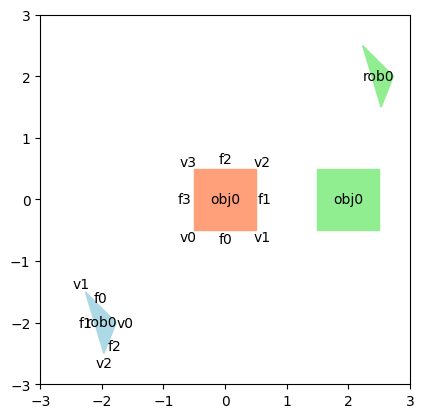

In [2]:
ws = 3
params = ContactGraphGeneratorParams(
    name="cg_simple_2",
    obs_vertices=[],
    obj_vertices=[np.array([[0, 0], [1, 0], [1, 1], [0, 1]]) + np.array([2.5, 0.5])],
    rob_vertices=[np.array([[-1, -1], [-1.5, -0.5], [-1.2, -1.5]])],
    source_obj_pos=[[0, 0]],
    source_rob_pos=[[-2, -2]],
    target_obj_pos=[[2, 0]],
    target_rob_pos=[[2.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws, ws], [-ws, ws]],
)
generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact sets for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 1 body pairs...
100%|██████████| 1/1 [00:00<00:00, 29.00it/s]
INFO:large_gcs.graph.contact_graph:Each body pair has on average 11.0 modes
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...
100%|██████████| 11/11 [00:00<00:00, 45.86it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 11/11 [00:00<00:00, 2752.82it/s]
INFO:large_gcs.graph.contact_graph:11 sets remain after removing 0 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 7738.57it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 8010.28it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
100%|██████████| 78/78 [00:03<00:00, 23.97it/s]

Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


INFO:large_gcs.graph.contact_graph:52 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 7780.81it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 52/52 [00:00<00:00, 3685.62it/s]
INFO:large_gcs.graph.graph:Adding 52 edges to graph...
100%|██████████| 52/52 [00:00<00:00, 4023.54it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=52, source=[array([0, 0]), array([-2, -2])], target=[array([2, 0]), array([2.500, 2.000])], workspace=array([[-3,  3],
       [-3,  3]]), default_costs_constraints=None)


In [3]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Loading 11 contact pair modes for 2 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 11 sets...


100%|██████████| 11/11 [00:00<00:00, 50.45it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 13/13 [00:00<00:00, 7756.18it/s]
INFO:large_gcs.graph.graph:Adding 13 vertices to graph...
100%|██████████| 13/13 [00:00<00:00, 6707.58it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 52/52 [00:00<00:00, 6986.48it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 52/52 [00:00<00:00, 3372.67it/s]
INFO:large_gcs.graph.graph:Adding 52 edges to graph...
100%|██████████| 52/52 [00:00<00:00, 3935.47it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 16), n_vertices=13, n_edges=52, source=[array([0, 0]), array([-2, -2])], target=[array([2, 0]), array([2.500, 2.000])], workspace=array([[-3,  3],
       [-3,  3]]), default_costs_constraints=None)


In [4]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.FULL,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.FULL
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'target', 'source'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.154, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 2 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {"('NC|obj0_f0-rob0_v1',)", 'target', 'source'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 2, vertex_coverage: 0.231, edge_coverage: 0.0192, time_wall_cloc

In [6]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_under)
gcs_astar = GcsAstar(
    cg,
    cost_estimator=cost_estimator,
    use_convex_relaxation=False,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.125, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 3 neighbors (0)


INFO:large_gcs.algorithms.gcs_astar:
n_vertices_visited: 3, n_edges_visited: 2, n_vertices_explored: 3, vertex_coverage: 0.188, edge_coverage: 0.0154, time_wall_clock: 0.0521, n_gcs_solves: 3, gcs_solve_time_total: 0.0125, gcs_solve_time_iter_mean: 0.00417, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0.00357, gcs_solve_time_iter_min: 0.00162, gcs_solve_time_iter_max: 0.00922, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node ('NC|obj0_f0-rob0_v1',)'s 9 neighbors (8.344288728574407)
INFO:large_gcs.algorithms.gcs_astar:
n_vertices_visited: 4, n_edges_visited: 6, n_vertices_explored: 11, vertex_coverage: 0.25, edge_coverage: 0.0462, time_wall_clock: 0.185, n_gcs_solves: 11, gcs_solve_time_total: 0.0417, gcs_solve_time_iter_mean: 0.00379, gcs_solve_time_last_10_mean: 0.00325, gcs_solve_time_iter_std: 0.00375, gcs_solve_time_iter_min: 0.00132, gcs_solve_time_iter_max: 0.0136, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node ('NC|obj0_f3-ro

In [7]:
sol = cg.solve(use_convex_relaxation=False)
print(sol)

is_success: True, cost: 10.9, time: 29.5, vertex_path: ['source', "('NC|obj0_f3-rob0_v0',)", "('IC|obj0_f3-rob0_v0',)", "('NC|obj0_v3-rob0_f2',)", 'target'], ambient_path: [array([0.000, 0.000, -2.000, -2.000]), array([0.000, 0.000, 0.000, 0.000, -2.000, -0.733, -2.000, -0.500, 0.000,
       0.000, 1.267, 1.500, 1.267, 1.500]), array([0.000, 2.000, 0.000, 0.000, -0.733, 1.267, -0.500, 0.500, 2.000,
       0.000, 2.000, 1.000, 2.000, 1.000, 0.000, 2.000]), array([2.000, 2.000, 0.000, 0.000, 1.267, 2.500, 0.500, 2.000, 0.000,
       0.000, 1.233, 1.500, 1.233, 1.500]), array([2.000, 0.000, 2.500, 2.000])], flows: [-0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, -0.0, -0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 

In [8]:
sol = cg.solve(use_convex_relaxation=True)
print(sol)

is_success: False, cost: 16.9, time: 0.503, vertex_path: [], ambient_path: [], flows: [], result: <pydrake.solvers.MathematicalProgramResult object at 0x1855a0830>


## Triangle Challenge 2

Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04


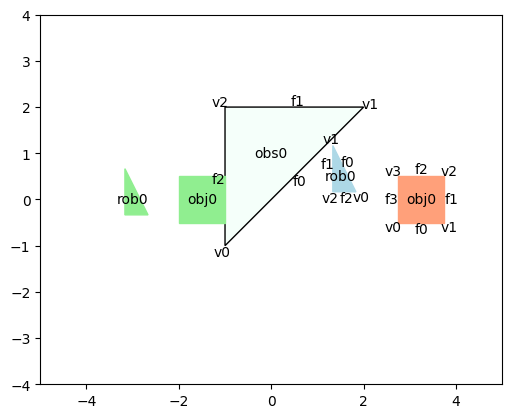

In [2]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal2",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.5]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[-3, 0]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [3]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact sets for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 50.25it/s]
INFO:large_gcs.graph.contact_graph:Each body pair has on average 6.666666666666667 modes
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:04<00:00, 52.94it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3632.01it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 8836.07it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 10612.70it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
  0%|          | 12/16290 [00:03<52:13,  5.20it/s]  

Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04

100%|██████████| 16290/16290 [00:04<00:00, 3488.25it/s] 
INFO:large_gcs.graph.contact_graph:6408 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6408/6408 [00:00<00:00, 8805.68it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6408/6408 [00:01<00:00, 4849.79it/s]
INFO:large_gcs.graph.graph:Adding 6408 edges to graph...
100%|██████████| 6408/6408 [00:01<00:00, 4115.34it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6408, source=[array([3.250, 0.000]), array([1.500, 0.500])], target=[array([-1.500, 0.000]), array([-3,  0])], workspace=array([[-5,  5],
       [-4,  4]]), default_costs_constraints=None)


In [4]:
cg = ContactGraph.load_from_file(params.graph_file_path)

INFO:large_gcs.graph.contact_graph:Loading 20 contact pair modes for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact sets for 179 sets...
100%|██████████| 179/179 [00:03<00:00, 49.75it/s]
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 9638.28it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 13481.00it/s]
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6408/6408 [00:00<00:00, 9620.39it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6408/6408 [00:01<00:00, 4723.01it/s]
INFO:large_gcs.graph.graph:Adding 6408 edges to graph...
100%|██████████| 6408/6408 [00:01<00:00, 4294.87it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6408, source=[array([3.250, 0.000]), array([1.500, 0.500])], target=[array([-1.500, 0.000]), array([-3,  0])], work

Just checking that everything works

In [5]:
cost_estimator = ShortcutEdgeCE(cg, shortcut_edge_cost_factory=contact_shortcut_edge_cost_factory_over_obj_weighted)
gcs_astar = GcsAstarConvexRestriction(
    cg,
    cost_estimator=cost_estimator,
    reexplore_level=ReexploreLevel.NONE,
)
sol = gcs_astar.run()

INFO:large_gcs.algorithms.gcs_astar_convex_restriction:Running GcsAstarConvexRestriction, reexplore_level: ReexploreLevel.NONE
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', 'target'}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 2, n_edges_visited: 0, n_vertices_explored: 0, vertex_coverage: 0.011, edge_coverage: 0, time_wall_clock: 0, n_gcs_solves: 0, gcs_solve_time_total: 0, gcs_solve_time_iter_mean: 0, gcs_solve_time_last_10_mean: 0, gcs_solve_time_iter_std: 0, gcs_solve_time_iter_min: inf, gcs_solve_time_iter_max: 0, n_vertices_revisited: 0, n_vertices_reexplored: 0
now exploring node source's 1 neighbors (0)
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:visited_fd_vertices: {'source', 'target', "('NC|obs0_f0-obj0_v3', 'NC|obs0_f0-rob0_v1', 'NC|obj0_f3-rob0_v0')"}
INFO:large_gcs.algorithms.gcs_astar_convex_restriction:
n_vertices_visited: 3, n_edges_visited: 1, n_vertices_explored: 1, vertex_coverage: 0

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>
INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 640x480 -pix_fmt rgba -r 20.0 -loglevel error -i pipe: -vcodec h264 -pix_fmt yuv420p -y /var/folders/sl/37m0k__51_3_5c5j02w201r40000gn/T/tmp6s13d8o5/temp.m4v


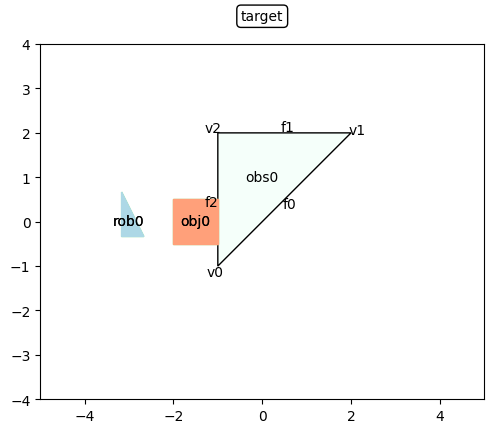

In [6]:
anim = cg.animate_solution()
HTML(anim.to_html5_video())

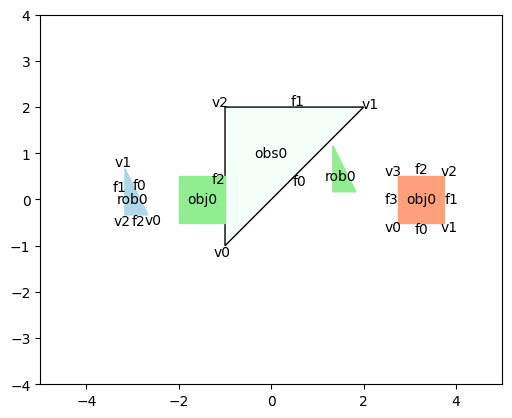

In [7]:
ws_x = 5
ws_y = 4
params = ContactGraphGeneratorParams(
    name="cg_trichal3",
    obs_vertices=[[[-1, 2], [-1, -1], [2, 2]]],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[-3, 0]],
    target_obj_pos=[[-1.5, 0]],
    target_rob_pos=[[1.5, 0.5]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [8]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact sets for 3 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 3 body pairs...
100%|██████████| 3/3 [00:00<00:00, 47.81it/s]
INFO:large_gcs.graph.contact_graph:Each body pair has on average 6.666666666666667 modes
INFO:large_gcs.graph.contact_graph:Generating contact sets for 216 sets...
100%|██████████| 216/216 [00:04<00:00, 52.23it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 216/216 [00:00<00:00, 3641.34it/s]
INFO:large_gcs.graph.contact_graph:179 sets remain after removing 37 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 181/181 [00:00<00:00, 7996.39it/s]
INFO:large_gcs.graph.graph:Adding 181 vertices to graph...
100%|██████████| 181/181 [00:00<00:00, 9600.50it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
  1%|          | 198/16290 [00:03<02:53, 92.68it/s] 

Set parameter Username
Set parameter UsernameSet parameter Username
Set parameter UsernameSet parameter UsernameSet parameter UsernameSet parameter UsernameSet parameter Username





Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Set parameter Username
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - for non-commercial use only - expires 2024-03-04
Academic license - f

100%|██████████| 16290/16290 [00:04<00:00, 3561.03it/s] 
INFO:large_gcs.graph.contact_graph:6408 edges generated
INFO:large_gcs.graph.contact_graph:Creating edge costs...
100%|██████████| 6408/6408 [00:00<00:00, 8987.04it/s]
INFO:large_gcs.graph.contact_graph:Creating edge constraints...
100%|██████████| 6408/6408 [00:01<00:00, 4776.38it/s]
INFO:large_gcs.graph.graph:Adding 6408 edges to graph...
100%|██████████| 6408/6408 [00:01<00:00, 4292.81it/s]
INFO:large_gcs.graph.contact_graph:Created contact graph: GraphParams(dim_bounds=(4, 18), n_vertices=181, n_edges=6408, source=[array([3.250, 0.000]), array([-3,  0])], target=[array([-1.500, 0.000]), array([1.500, 0.500])], workspace=array([[-5,  5],
       [-4,  4]]), default_costs_constraints=None)


In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

In [ ]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a1",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[3.25, 0]],
    source_rob_pos=[[1.5, 0.6]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [ ]:
generator.generate()

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)

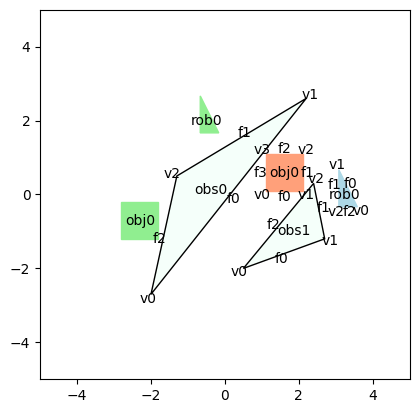

In [21]:
ws_x = 5
ws_y = 5
params = ContactGraphGeneratorParams(
    name="cg_maze_a2",
    obs_vertices=[
        [[-2, -2.7], [2.2, 2.6], [-1.3, 0.5]],
        [[0.5, -2], [2.7, -1.2], [2.4, 0.3]],
    ],
    obj_vertices=[[[1, 0.5], [1, -0.5], [2, -0.5], [2, 0.5]]],
    rob_vertices=[[[3, 1], [3, 0], [3.5, 0]]],
    source_obj_pos=[[1.6, 0.6]],
    source_rob_pos=[[3.25, 0]],
    target_obj_pos=[[-2.3, -0.7]],
    target_rob_pos=[[-0.5, 2]],
    n_pos_per_set=2,
    workspace=[[-ws_x, ws_x], [-ws_y, ws_y]],
)

generator = ContactGraphGenerator(params)
generator.plot()

In [22]:
generator.generate()

INFO:large_gcs.graph.contact_graph:Generating contact sets for 4 bodies...
INFO:large_gcs.graph.contact_graph:Generating contact pair modes for 5 body pairs...
100%|██████████| 5/5 [00:00<00:00, 58.27it/s]
INFO:large_gcs.graph.contact_graph:Each body pair has on average 10.0 modes
INFO:large_gcs.graph.contact_graph:Generating contact sets for 70560 sets...
100%|██████████| 70560/70560 [20:10<00:00, 58.29it/s]
INFO:large_gcs.graph.contact_graph:Pruning empty sets...
100%|██████████| 70560/70560 [09:16<00:00, 126.72it/s]
INFO:large_gcs.graph.contact_graph:11931 sets remain after removing 58629 empty sets
INFO:large_gcs.graph.contact_graph:Creating vertex costs...
100%|██████████| 11933/11933 [00:00<00:00, 13806.72it/s]
INFO:large_gcs.graph.graph:Adding 11933 vertices to graph...
100%|██████████| 11933/11933 [00:00<00:00, 13175.94it/s]
INFO:large_gcs.graph.contact_graph:Generating edges...(parallel)
  0%|          | 268753/71192278 [07:52<34:36:51, 569.16it/s]


KeyboardInterrupt: 

In [ ]:
cg = ContactGraph.load_from_file(params.graph_file_path)